In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from pgmpy.inference import VariableElimination
from causalgraphicalmodels import CausalGraphicalModel
from IPython.display import display

In [24]:
# Load the dataset

data = pd.read_csv("Movie Final Data.csv")

In [25]:
# Select relevant features
selected_columns = [
    "Production Budget (USD)", "Opening Weekend (USD)", "Max Theaters", "Weeks Run",
    "Genre", "MPAA Rating", "Budget_to_WorldGross_Ratio", "Domestic_vs_International_Ratio", "Worldwide Box Office (USD)"
]
data = data[selected_columns].dropna()

In [26]:
# Create BoxOfficeSuccess based on median worldwide revenue
data["BoxOfficeSuccess"] = data["Worldwide Box Office (USD)"].apply(lambda x: "hit" if x > data["Worldwide Box Office (USD)"].median() else "flop")

# Discretize continuous variables (binning into categories)
data["Production Budget (USD)"] = pd.qcut(data["Production Budget (USD)"], q=3, labels=["low", "medium", "high"])
data["Opening Weekend (USD)"] = pd.qcut(data["Opening Weekend (USD)"], q=3, labels=["low", "medium", "high"])
data["Max Theaters"] = pd.qcut(data["Max Theaters"], q=3, labels=["small", "medium", "large"])
data["Weeks Run"] = pd.qcut(data["Weeks Run"], q=3, labels=["short", "average", "long"])


In [27]:
# Define Bayesian Network Structure
model = BayesianNetwork([
    ("Production Budget (USD)", "Opening Weekend (USD)"),
    ("Opening Weekend (USD)", "BoxOfficeSuccess"),
    ("Genre", "BoxOfficeSuccess"),
    ("MPAA Rating", "BoxOfficeSuccess"),
    ("Max Theaters", "BoxOfficeSuccess"),
    ("Weeks Run", "BoxOfficeSuccess")
])

In [28]:
# Train the Bayesian Network
model.fit(data, estimator=MaximumLikelihoodEstimator)

In [29]:
# Display learned CPDs
for cpd in model.get_cpds():
    print(f"CPD for {cpd.variable}:", cpd)

CPD for Production Budget (USD): +---------------------------------+----------+
| Production Budget (USD)(high)   | 0.333148 |
+---------------------------------+----------+
| Production Budget (USD)(low)    | 0.344086 |
+---------------------------------+----------+
| Production Budget (USD)(medium) | 0.322766 |
+---------------------------------+----------+
CPD for Opening Weekend (USD): +-------------------------------+-----+---------------------------------+
| Production Budget (USD)       | ... | Production Budget (USD)(medium) |
+-------------------------------+-----+---------------------------------+
| Opening Weekend (USD)(high)   | ... | 0.2670878805284319              |
+-------------------------------+-----+---------------------------------+
| Opening Weekend (USD)(low)    | ... | 0.2527283170591614              |
+-------------------------------+-----+---------------------------------+
| Opening Weekend (USD)(medium) | ... | 0.48018380241240666             |
+--------------

#### CPD for Production Budget: 
The dataset is fairly balanced across low, medium, and high budgets. No significant skew—movies are evenly distributed in terms of budget

#### CPD for Opening Weekend (USD):
48% of movies fall into the "medium" opening weekend range. High and low openings occur at a similar rate (~25% each). This suggests most movies have mid-tier openings, but extremes (blockbusters or flops) are less common.

#### CPD for BoxOfficeSuccess:
Movies in the Western genre have 0% probability of being a hit. R-rated movies also seem to have very poor success rates.
If a movie opens in a small number of theaters, it is guaranteed to flop. If a movie has a medium opening weekend but only runs for a short period, it will fail. Western movies struggle at the box office. R-rated movies have a harder time succeeding, likely due to restricted audiences. Small releases and short runs strongly predict failure.

#### CPD for Genre Distribution:
Drama (27%) and Comedy (24%) are the most common genres. Westerns (~1%) and Musicals (~1.6%) are rare in the dataset.
Horror (8.5%) and Thriller (9.9%) are relatively small categories. Since Western movies already have a low probability of success (0%), and they only make up ~1% of movies, studios should avoid investing in Westerns unless other success factors are very strong.

#### CPD for MPAA Rating:
PG-rated movies dominate (49%), followed closely by R-rated (44%). NC-17 movies are extremely rare (~0.16%). G-rated movies are also uncommon (~1.85%). PG movies are the safest bet since they have a wide audience. NC-17 movies are extremely rare and may struggle to succee

#### CPD for Theater Count:
Equal distribution of movies across small, medium, and large releases.

#### CPD for Weeks Run:
Even distribution across short, medium, and long-running movies.


In [30]:
# Perform Inference
inference = VariableElimination(model)
result = inference.query(variables=["BoxOfficeSuccess"], evidence={"Production Budget (USD)": "high", "Max Theaters": "large"})
print("Probability of BoxOfficeSuccess given high budget & large theater count:", result)

Probability of BoxOfficeSuccess given high budget & large theater count: +------------------------+-------------------------+
| BoxOfficeSuccess       |   phi(BoxOfficeSuccess) |
+========================+=========================+
| BoxOfficeSuccess(flop) |                  0.1877 |
+------------------------+-------------------------+
| BoxOfficeSuccess(hit)  |                  0.8123 |
+------------------------+-------------------------+


A 81.23% probability of success, and a 18.77% probability of failure This suggests that movies with high budgets and wide releases have a strong chance (81%) of being a hit, but success is not guaranteed.


In [22]:
import os
os.environ["PATH"] += os.pathsep + "/Users/yidiwang/opt/miniconda3/envs/pgmpy_env/bin"

<class 'graphviz.graphs.Digraph'>
Model: Bayesian Network Model


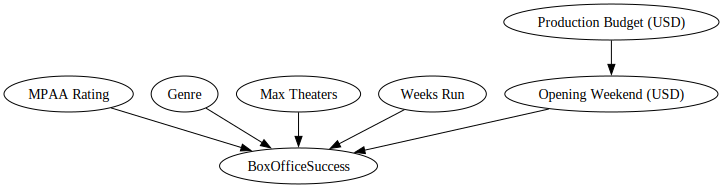

In [31]:
# Visualize the Bayesian Network using CausalGraphicalModel
def draw_model(model, title, filename):
    graph = CausalGraphicalModel(nodes=model.nodes(), edges=model.edges())
    dot = graph.draw()
    print(type(dot))
    print(f"Model: {title}")
    display(dot)
    dot.render(filename=filename, format="pdf")  

draw_model(model, title="Bayesian Network Model", filename="bayesian_network")

In the Bayesian Network Structure, Nodes represent variables in the model, such as Production Budget, Opening Weekend, Genre, MPAA Rating, Max Theaters, Weeks Run, and BoxOfficeSuccess.
For example, “Production Budget (USD)" → "Opening Weekend (USD)" suggest that higher budgets impact opening weekend revenue; and "Opening Weekend (USD)" → "BoxOfficeSuccess" indicates that a strong opening weekend is a predictor of overall success.